In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import cm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

## Анализ матриц синхронизации для  состояния с открытыми и закрытыми глазами

Данные: ЭЭГ

Результаты представлены в трёх массивах формата xls, каждый из которых содержит результаты
для независимых групп испытуемых численностью 59 человек. Каждый столбец массивов,
начиная со столбца 2, содержит результаты отдельного испытуемого. Первая строка массива ,
начиная со столбца 2, содержит трехбуквенные идентификаторы испытуемых, чьи результаты
находятся в соответствующем столбце. Первый столбец массива, начиная со строки 2, содержит
записи, указывающие на пару отведений в принятых обозначениях для ЭЭГ отведений системы 10-
20, на номер частотного диапазона (1-δ, 2-θ, 3-α1, 4-α2, 5-β1, 6-β2, 7-γ) и на состояние (fo – покой
с открытыми глазами, fz – покой с закрытыми глазами).


In [2]:
df = pd.read_csv('eeg_dataframe_nansfilled.csv', index_col=0)
col_names = [el.strip() for el in df.columns]
df.columns = col_names

In [3]:
def jaccard(set1,set2):
    return len(set(set1).intersection(set(set2)))/len(set(set1).union(set(set2))) 

def dice(set1, set2):
    if len(set1)==0 or len(set2)==0:
        return 0
    else:
        return 2*len(set(set1).intersection(set(set2)))/(len(set(set1))+len(set(set2)))
class EEGPairedPermutationAnalyser:
    def __init__(self, data_df = None, num_perm = 1000, thres = 0.001):
        self.df = data_df.copy()
        self.thres = thres
        self.channel_bivar = np.unique([el.split('_')[0] for el in list(self.df.columns)])
        self.num_perm = num_perm
        self.open_name = None
        self.close_name = None
        self.subgroup_ids = list(self.df.index)
        self.size = len(self.subgroup_ids)
        self.key_bands = {1: 'delta', 2: 'theta', 3: 'alpha1', 4: 'alpha2', 5: 'beta1', 6: 'beta2', 7: 'gamma'}

        
    def get_subgroup(self, size = 70):
        """function return subgroup from the total group with unique ids
        """
        self.subgroup_ids = list(np.random.choice(self.df.index, size = size, replace=False))
        
    def compute_reproducible_pattern(self, size = 70, num_reps = 50, factor = 0.4, band = 1):
        most_frequent_list = []
        sign_tested, (metric_list, cnt) = self.pairwise_set_comparisons(size = size, band = band, num_reps = num_reps)
        most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*factor}
        most_frequent_list = list(self.channel_bivar[list(most_frequent.keys())])
        most_frequent_freqs = np.array(list(most_frequent.values()))/num_reps
        most_frequent_values = []
        for chan in most_frequent_list:
            chan_id = list(self.channel_bivar).index(chan)
            chan_values = []
            for chan_dict in sign_tested:
                if chan_id in chan_dict.keys():
                    chan_values.append(chan_dict[chan_id])
            most_frequent_values.append(np.mean(chan_values)) 
        return (most_frequent_list, most_frequent_freqs, most_frequent_values), metric_list    
        
    def test_reproducability(self, size = 70, band = 1, num_reps = 100):
        
        sign_channels = []
        for i in tqdm(range(num_reps)):
            self.get_subgroup(size = size)
            (emp_stat,p_val),_  = self.perm_difference_paired(band = band)  
            sign_channel_ids = np.where(p_val<self.thres)[0]
            
            sign_channels_values = emp_stat[sign_channel_ids]
            sign_channels.append(dict(zip(sign_channel_ids, sign_channels_values)))
        return sign_channels
    
    def pairwise_set_comparisons(self, size = 70, band = 1, num_reps=10, func = dice, type_ = 'neigh'):
        
        assert type_ in ['neigh', 'all'], "type_ variable should be 'neigh' or 'all'"
        metric_list = []
        sign_tested = self.test_reproducability(size = size, band = band, num_reps = num_reps)
        chns = [list(els.keys()) for els in sign_tested]
        cnt  = Counter(np.hstack(chns))
        if type_== 'neigh':
            for i in range(len(sign_tested)-1):
                metric_list.append(func(list(sign_tested[i].keys()),list(sign_tested[i+1].keys())))
        else:        
            for i, list1 in enumerated(len(sign_tested)):
                for j, list2 in enumerated(len(sign_tested)):
                    if i!=j:
                        metric_list.append(func(list(list1.keys()),list(list2.keys())))
        return sign_tested, (metric_list, cnt)
    
    def compare_to_etalon(self, size = 70, band = 1, num_reps = 100):
        self.subgroup_ids = list(self.df.index)
        (emp_stat,p_val),_  = self.perm_difference_paired(band = band) 
        sign_etalon = np.where(p_val<self.thres)[0]
        sign_tested = self.test_reproducability(size = size, band = band, num_reps = num_reps)
        cnt  = Counter(np.hstack(sign_tested))
        jac_list = []
        for sign_list in sign_tested:
            jac_list.append(jaccard(sign_list,sign_etalon))
        return (jac_list,cnt), sign_etalon, sign_tested    
    
    
    
    def perm_difference_paired(self, band = 1):
        
        self.open_name = [f'{self.channel_bivar[i]}_{band}_fo' for i in range(len(self.channel_bivar))]
        self.close_name = [f'{self.channel_bivar[i]}_{band}_fz' for i in range(len(self.channel_bivar))]
        df_sbgroup = self.df.loc[self.subgroup_ids]

        
        emp_diffs =  df_sbgroup[self.open_name].values - df_sbgroup[self.close_name].values
        emp_mean_diffs = emp_diffs.mean(axis=0)
        
        perm_mean_diffs = np.zeros((self.num_perm, emp_diffs.shape[1]))
        
        for k in np.arange(self.num_perm):
            perm_mean_diffs[k,:] = (np.random.choice([1,-1], emp_diffs.shape[0]).reshape(-1,1)*emp_diffs).mean(axis=0)
        p_val = np.mean(np.abs(perm_mean_diffs)>np.abs(emp_mean_diffs), axis=0) 
        return (emp_mean_diffs, p_val), perm_mean_diffs
    
    
    def plot_chnl_perm_test(self,emp_stat = None, perm_stats = None,  ch_idx=0, band = 1):
        
        if  (emp_stat is None) or (perm_stats is None):
            (emp_stat,_), perm_stats,  = self.perm_difference_paired(band = 1)      
        val = plt.hist(perm_stats[:,ch_idx], density = True)
        plt.vlines(emp_stat[ch_idx], 0, max(val[0]), 'red',  label = 'Observed stat');
        plt.vlines(np.percentile(perm_stats[:,ch_idx], 2.5), 0, max(val[0]), 'black',  label = '2.5 alpha level');
        plt.vlines(np.percentile(perm_stats[:,ch_idx], 97.5), 0, max(val[0]), 'black', label = '97.5 alpha level');
        plt.vlines(np.percentile(perm_stats[:,ch_idx], 95), 0, max(val[0]), 'black', label = '95 alpha level');
        plt.title(f"Permutation difference for channels {self.channel_bivar[ch_idx]} for band {self.key_bands[band]} ")
        plt.legend();
        
    def significant_channels(self, band = 1, 
                             plot = True, num_btsp = 1000, conf_levels = [5,95]):
        
        
        (emp_mean_diffs, p_val), perm_mean_diffs = self.perm_difference_paired(band = band)

        sign_connections = np.where(p_val<self.thres)[0]
        df_sbgroup = self.df.loc[self.subgroup_ids]
        size = df_sbgroup.shape[0]

        bstp_emp_diffs = []

        for i in tqdm(range(num_btsp)):
           
            b_df = df_sbgroup.loc[list(np.random.choice(df_sbgroup.index, size = size, replace=True))]
            b_emp_diffs = b_df[self.open_name].values - b_df[self.close_name].values
            bstp_emp_diffs.append(b_emp_diffs.mean(axis=0))
            
        conf_ints = np.percentile(np.array(bstp_emp_diffs),conf_levels, axis=0)    
        if plot:
            fig, ax = plt.subplots(1,1, figsize = (16,4))

            ax.plot(range(len(sign_connections)), emp_mean_diffs[sign_connections], '*');
            ax.vlines(range(len(sign_connections)),conf_ints[0, sign_connections], conf_ints[1, sign_connections], colors='gray')
            ax.set_xticks(range(len(sign_connections)))
            ax.set_xticklabels(self.channel_bivar[sign_connections], rotation=90, fontsize=10); 
            ax.set_title(f'Significant edges for band {self.key_bands[band]}')
        return dict(zip(self.channel_bivar[sign_connections], 
                        [(emp_mean_diffs[sign_connections],p_val[sign_connections]), conf_ints[:, sign_connections]]))    
    
    

## Графика

In [4]:
class DrawEEG:
    def __init__(self, img_source = None):
        self.sens =  ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
        'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
        self.number_of_channles = len(self.sens)
        if img_source is None:
            self.img = img.imread('21ch_eeg.png')
        else:
            self.img = img.imread(img_source)
        self.el_centers_dict = {"Cz": (197,181), "C3" : (134,181),
                                "C4" : (261,181), "T3" : (70,181), "T4" : (324,181),
                                "Fz" : (197,117), "F3" : (146,116), "F4" : (250,116),
                                "F7" : (95,107), "F8" : (300,107), "Fp1" : (156,61),
                                "Fp2" : (239,61), "O1" : (157,301), 
                                "O2" : (238,301), "Pz" : (197,245),
                                "P3" : (146,245), "P4" : (250,245), "T5" : (95,255),
                                "T6" : (300,255)} 
        self.bands = ['delta', 'theta', 'alpha1','alpha2','beta1', 'beta2', 'gamma']
    def draw_edges(self, pair_names, values_color = None, values_width = None, 
                   normalize_values = True, normalize_width = True, cmap = cm.cool, title = "Hey, hey!", ax = None):
        
        """ draw edges 
        Args:
            pair_names (list of string): list of string in format 'cn1/cn2' ('F3/C3')
            values_color (array of floats): value from 0 to 1
            values_width (array of floats): should be positive value near 1  
        """
        if ax is None:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (5,5))
        chan_pairs  = [el.split('/') for el in list(pair_names)]
        if values_color is None:
            values_color = 0.9*np.ones(len(pair_names))
        if values_width is None:
            values_width = 0.9*np.ones(len(pair_names))
        if normalize_values:
            max_ = np.max(values_color)
            min_ = np.min(values_color)
            if max_>min_:
                values_color = (values_color - min_)/(max_-min_)
        if normalize_width:
            abs_max_ = np.max(np.abs(values_width))
            values_width = np.abs(values_width)/abs_max_

        for idx in range(len(chan_pairs)):
            chan_pair = chan_pairs[idx]
            els =np.array([self.el_centers_dict[chan_pair[0]],self.el_centers_dict[chan_pair[1]]])
            col = cmap(values_color[idx])
            
            ax.plot(els[:,0], els[:,1], color=col, alpha=1, linewidth = 4*values_width[idx]);
        ax.imshow(self.img);
        ax.set_title(title)
        ax.axis('off');
            

## Разница между состояниями

Оцениваем разницу между состояниями с помощью теста на перемешивание. То есть считаем разницу между состояниями для каждого человека, усредняем по людям, затем путаем состояния, снова считаем разницу, снова усредняем и смотрим сколько раз у нас значение превысило реальное: это и будет оценка p-val. Это процедуру мы можем делать как на полной выборке, так и на подвыборке. У нас задача  - посмотреть насколько паттерны, выявленные по целой выборке совпадают на подвыборке

### Для "конкретного эксперимента" посмотрим значимые пары каналов вместе с доверительными интервалами значений

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 552.87it/s]


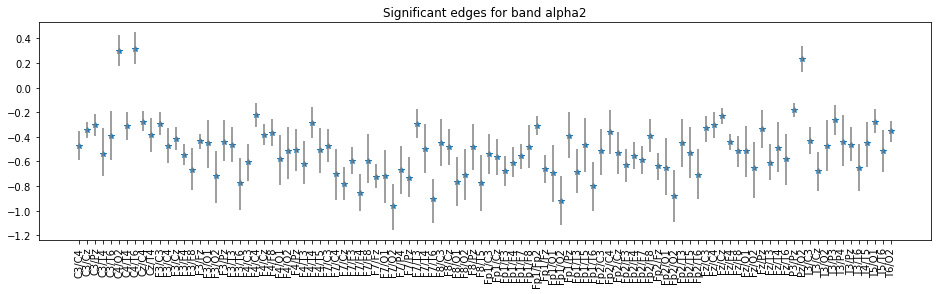

In [5]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
SUBGROUP = True
group_size=100
#берем произвольную подгруппу
if SUBGROUP:
    eeg_analyser.get_subgroup(size = group_size)
sign_channels = eeg_analyser.significant_channels(band = 4)

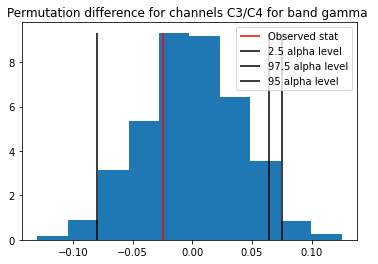

In [6]:
eeg_analyser.plot_chnl_perm_test(ch_idx=0, band = 7)

## Непараметрическая оценка значимости межканальной синхронизации 

Для выборки целиком или под выборки для каждого частотного диапазона оцениваем с помощью перемешивания значимость

На выходе получаем списки значимых пар, и средний коэффициент разницы в синхронизации между состояниями


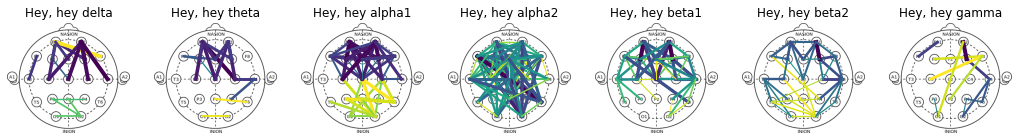

In [7]:
#инициализируем  EEG, вариант для однократного анализа
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.00025, num_perm = 1000)
#берем произвольную подгруппу
group_size=100
#берем произвольную подгруппу
if SUBGROUP:
    eeg_analyser.get_subgroup(size = group_size)
list_chan_to_draw = []
list_sign_channels_values = []
for i in range(1,8):
    (emp_mean_diffs, p_val), perm_mean_diffs = eeg_analyser.perm_difference_paired(band=i)
    sign_channel_ids = np.where(p_val<eeg_analyser.thres)[0]
    chan_to_draw = eeg_analyser.channel_bivar[sign_channel_ids]
    list_chan_to_draw.append(chan_to_draw)
    sign_channels_values = emp_mean_diffs[sign_channel_ids]
    list_sign_channels_values.append(sign_channels_values)
fig, axs = plt.subplots(nrows=1, ncols=7, figsize = (18,4))
obj = DrawEEG()
for i in range(7):
    obj.draw_edges(list_chan_to_draw[i], values_color = list_sign_channels_values[i], values_width = list_sign_channels_values[i],
                   cmap = cm.viridis, ax=axs[i], title = f"Hey, hey {obj.bands[i]}")    

## Оценка воспроизводимости
Смотрим теперь какие паттерны будут получаться если будем повторять эксперимент
Идея: давайте оставлять только те пары каналов, которые воспроизводятся более чем в какой-то доле случаев (половина, треть, отвечает за это factor)

Будем выводить только их

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 15.71it/s]


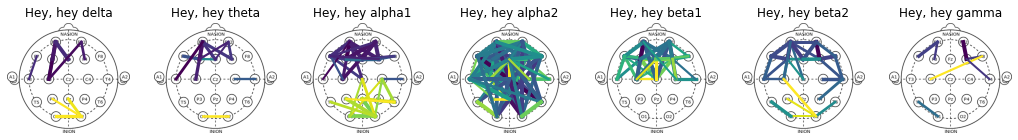

In [8]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.0005, num_perm = 1000)
size = 80 #размер группы
num_reps = 50 #количество повторений с таким размером группы
factor = 0.5 # пороговая доля с которой должна повторяться связь
bands_mf_list = []
bands_mf_freqs = []
bands_mf_values = []
for i in range(1,8):
    (mf_list, mf_freqs, mf_values), metric_list  = eeg_analyser.compute_reproducible_pattern(size = size,
                                                                                             num_reps = num_reps, factor = factor, band = i)
    bands_mf_list.append(mf_list)
    bands_mf_freqs.append(mf_freqs)
    bands_mf_values.append(mf_values)

fig, axs = plt.subplots(nrows=1, ncols=7, figsize = (18,4))
obj = DrawEEG()
for i in range(7):
    obj.draw_edges(bands_mf_list[i], values_color = bands_mf_values[i], values_width = bands_mf_freqs[i],
                   cmap = cm.viridis, ax=axs[i], normalize_width = False, title = f"Hey, hey {obj.bands[i]}")        

In [9]:
#значимые каналы для конкретной частотной полосы
band_id = 1
sign_df = pd.DataFrame([bands_mf_list[band_id],  bands_mf_freqs[band_id], bands_mf_values[band_id]]).T
sign_df.columns = ["ChanPair", "ReprFactor", "Synh diff"]
display(sign_df)

,ChanPair,ReprFactor,Synh diff
0,C4/T4,0.58,-0.234173
1,F3/Fz,0.56,-0.124594
2,F7/F3,0.82,-0.25429
3,Fp1/C3,0.82,-0.352811
4,Fp1/F3,1.0,-0.374442
5,Fp1/F4,0.78,-0.311967
6,Fp1/Fz,0.8,-0.316007
7,Fp1/T3,0.7,-0.404957
8,Fp2/F3,0.54,-0.350602
9,Fp2/F4,0.68,-0.312478


### !!! Дальше не смотреть

In [10]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.0005, num_perm = 1000)
sign_tested = eeg_analyser.test_reproducability(size = size, band = 0, num_reps = num_reps)

  0%|                                                    | 0/50 [00:00<?, ?it/s]


KeyError: "None of [Index(['C3/C4_0_fo', 'C3/Cz_0_fo', 'C3/O1_0_fo', 'C3/O2_0_fo', 'C3/P3_0_fo',\n       'C3/P4_0_fo', 'C3/Pz_0_fo', 'C3/T4_0_fo', 'C3/T5_0_fo', 'C3/T6_0_fo',\n       ...\n       'T4/T5_0_fo', 'T4/T6_0_fo', 'T5/O1_0_fo', 'T5/O2_0_fo', 'T5/P3_0_fo',\n       'T5/P4_0_fo', 'T5/Pz_0_fo', 'T5/T6_0_fo', 'T6/O1_0_fo', 'T6/O2_0_fo'],\n      dtype='object', length=171)] are in the [columns]"

In [50]:
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = size, band = 7, num_reps = num_reps)

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 20.06it/s]


TypeError: unhashable type: 'dict'

In [401]:
most_frequent_values = []
for chan in most_frequent_list:
    chan_id = list(eeg_analyser.channel_bivar).index(chan)
    chan_values = []
    for chan_dict in sign_tested:
        if chan_id in chan_dict.keys():
            chan_values.append(chan_dict[chan_id])
    most_frequent_values.append(np.mean(chan_values))    
    

In [402]:
most_frequent_values

[-0.5047731375729604,
 -0.4349147074767115,
 -0.39243076542795036,
 0.22707488917078097,
 0.22700554500898198,
 0.21599342422368256,
 -0.2527508328020327,
 -0.4841020977659432,
 -0.4029120270444086]

In [376]:
list_chan_to_draw[i]

array(['F4/F8', 'F4/T4', 'F7/C4', 'F7/Cz', 'F7/F3', 'F8/C3', 'F8/O1',
       'F8/P3', 'F8/T4', 'Fp1/F3', 'Fp1/F7', 'Fp1/Fp2', 'Fp1/Fz',
       'Fp2/F4', 'Fp2/F8', 'Fp2/O1', 'P3/O1', 'P4/O2', 'P4/T6', 'T4/O2',
       'T4/T6', 'T5/O1', 'T5/P3', 'T5/Pz', 'T6/O2'], dtype='<U7')

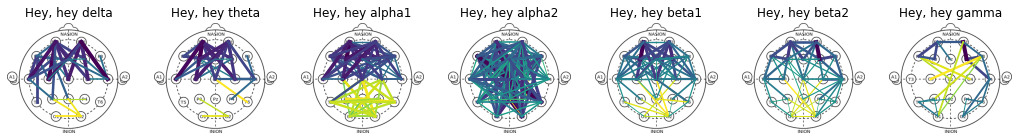

In [361]:
fig, axs = plt.subplots(nrows=1, ncols=7, figsize = (18,4))
obj = DrawEEG()
for i in range(7):
    obj.draw_edges(list_chan_to_draw[i], values_color = list_sign_channels_values[i], values_width = list_sign_channels_values[i],
                   cmap = cm.viridis, ax=axs[i], title = f"Hey, hey {obj.bands[i]}")
#cbar_ax = fig.add_axes([0.15, 0.1, 0.75, 0.1]);
#cbar_ax.axis('off');

In [362]:
#list_chan_to_draw, list_sign_channels_values

In [238]:
chan_to_draw = eeg_analyser.channel_bivar[sign_channel_ids]
chan_values = sign_channels_values

In [240]:
chan_to_draw, chan_values

(array(['F3/C3', 'F3/T3', 'F7/Fz', 'Fp1/C3', 'Fp1/F3', 'Fp1/Fz', 'Fp1/T3',
        'O1/O2', 'P3/O2', 'Pz/O2', 'T3/C3'], dtype='<U7'),
 array([-0.27637423, -0.5150212 , -0.47416892, -0.53929212, -0.50234613,
        -0.39320356, -0.52906253,  0.20948286,  0.18700827,  0.20955319,
        -0.3486863 ]))

In [233]:
sign_channels = eeg_analyser.test_reproducability(size = 70, band = 1, num_reps = 10)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.82it/s]


In [84]:
#инициализируем, задаем число симуляций для теста на значимость и порог
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.0005, num_perm = 1000)
metric_list, cnt = eeg_analyser.pairwise_set_comparisons(size = 30, 

In [25]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.0005, num_perm = 5000)

sign_tested, (metric_list, cnt) = eeg_analyser.pairwise_set_comparisons(size = 50, band = 1, num_reps=100, func = dice)

100%|█████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


In [119]:
#cnt.most_common()

In [28]:
most_frequent = { x: count for x, count in cnt.items() if count >= 10}
most_frequent

{83.0: 41,
 86.0: 55,
 91.0: 45,
 97.0: 17,
 101.0: 28,
 103.0: 15,
 142.0: 33,
 27.0: 31,
 102.0: 12,
 105.0: 24,
 132.0: 47,
 134.0: 24,
 115.0: 16,
 67.0: 19,
 38.0: 16,
 108.0: 10}

In [27]:
most_frequent.keys()
chan_to_draw = eeg_analyser.channel_bivar[list(most_frequent.keys())]
strength = np.array(list(most_frequent.values()))/50

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 454.29it/s]


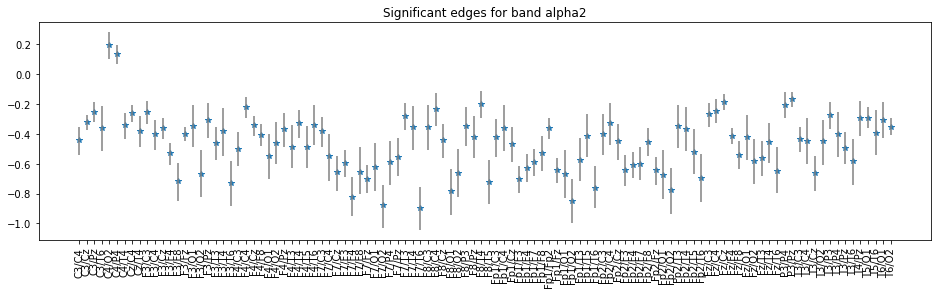

In [24]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
sign_channels = eeg_analyser.significant_channels(band = 4)

In [74]:
sign_channels.keys()

dict_keys(['C3/C4', 'C3/Cz'])

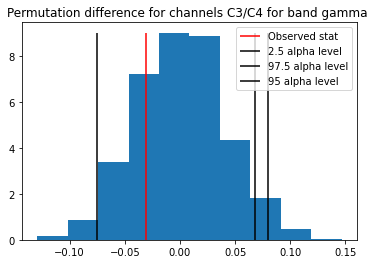

In [43]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
mean_jac = []
size_list = [20,30,50,70,100,120,150, 170]
most_frequent_list = []
for size in size_list:
    (jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = size, band = 7, num_reps = num_reps)

    #print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
    mean_jac.append(np.mean(jac_list))
    most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
    most_frequent_list.append(list(eeg_analyser.channel_bivar[list(most_frequent.keys())]))
pd.DataFrame([size_list, mean_jac, most_frequent_list]).T    

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 19.99it/s]


TypeError: unhashable type: 'dict'

,0,1,2
0,20,0.018052,[]
1,30,0.062461,[]
2,50,0.148999,[Fp2/F4]
3,70,0.222448,"[F8/C3, Fp1/F7, Fp2/F4]"
4,100,0.453407,"[F4/F8, F4/T4, F8/C3, Fp1/F3, Fp2/F4, P3/O1, P..."
5,120,0.542504,"[F4/F8, F4/T4, F7/F3, Fp1/F3, Fp1/F7, Fp2/F4, ..."
6,150,0.645643,"[C4/T6, F4/F8, F4/T4, F7/C4, F7/F3, F8/C3, F8/..."
7,170,0.78377,"[C4/T6, F4/F8, F4/T4, F7/C4, F7/F3, F8/C3, F8/..."


In [45]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 50,
                                                                           band = 2, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.1 }
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.65it/s]


TypeError: unhashable type: 'dict'

In [11]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 20, band = 2, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5 }
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 22.70it/s]

Средний коэффициент джакарда: 0.03545093676672625


array([], dtype='<U7')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 606.93it/s]


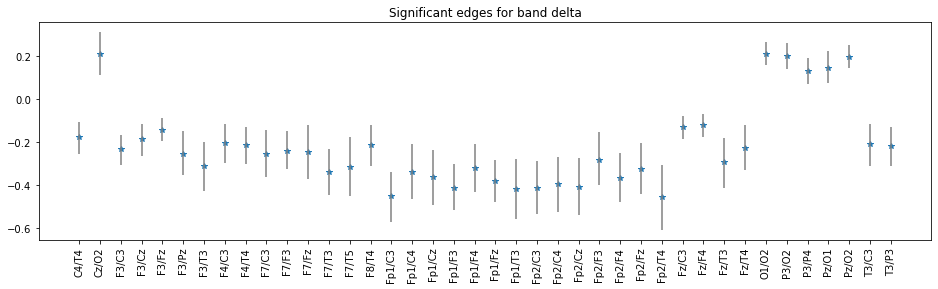

In [13]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
sign_channels = eeg_analyser.significant_channels(band = 1)

In [20]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 100, band = 1, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.11it/s]

Средний коэффициент джакарда: 0.40109914891241816


array(['F3/C3', 'F7/T3', 'Fp1/C3', 'Fp1/Cz', 'Fp1/F3', 'Fp1/Fz', 'Fp2/C3',
       'Fp2/C4', 'Fp2/Cz', 'Fp2/F4', 'O1/O2', 'P3/O2', 'Pz/O2', 'Fp2/T4',
       'Fp1/T3'], dtype='<U7')

In [21]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 50, band = 1, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.75it/s]

Средний коэффициент джакарда: 0.15522014447150517


array(['Fp1/F3', 'Fp1/Fz'], dtype='<U7')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 560.73it/s]


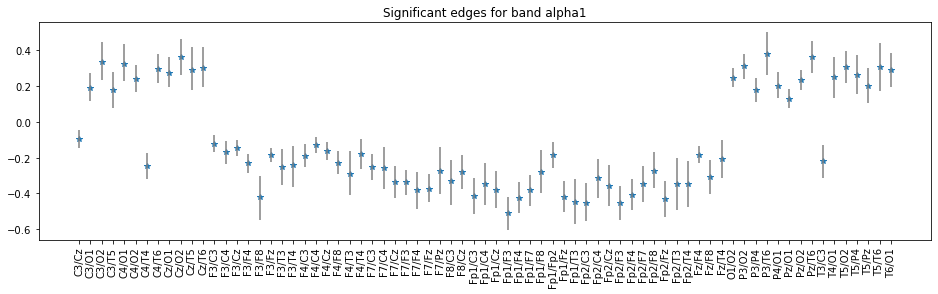

In [22]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
sign_channels = eeg_analyser.significant_channels(band = 3)

In [24]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 100, band = 3, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.06it/s]

Средний коэффициент джакарда: 0.5964781057524563


array(['C3/O2', 'C4/O2', 'C4/T6', 'Cz/O2', 'F3/Cz', 'F3/F4', 'F3/F8',
       'F3/Fz', 'F4/Cz', 'F4/F8', 'F7/C3', 'F7/Cz', 'F7/F3', 'F7/F4',
       'F7/Fz', 'F8/Cz', 'Fp1/C3', 'Fp1/Cz', 'Fp1/F3', 'Fp1/F4', 'Fp1/F7',
       'Fp1/Fz', 'Fp1/T3', 'Fp2/C3', 'Fp2/C4', 'Fp2/Cz', 'Fp2/F3',
       'Fp2/F4', 'Fp2/F7', 'Fp2/Fz', 'Fz/F4', 'Fz/F8', 'O1/O2', 'P3/O2',
       'P3/T6', 'P4/O1', 'Pz/O2', 'Pz/T6', 'T5/O2', 'T6/O1', 'C4/O1',
       'C4/T4', 'Cz/O1', 'Fp2/F8', 'Fp1/C4'], dtype='<U7')

In [25]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 50, band = 3, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.23it/s]

Средний коэффициент джакарда: 0.30288956669584194


array(['F3/F4', 'F3/Fz', 'F7/F3', 'F7/Fz', 'Fp1/F3', 'Fp1/F4', 'Fp1/F7',
       'Fp1/Fz', 'Fp2/F3', 'Fp2/F4', 'Fp2/Fz', 'Fz/F4', 'O1/O2', 'P3/O2',
       'Pz/O2'], dtype='<U7')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 585.51it/s]


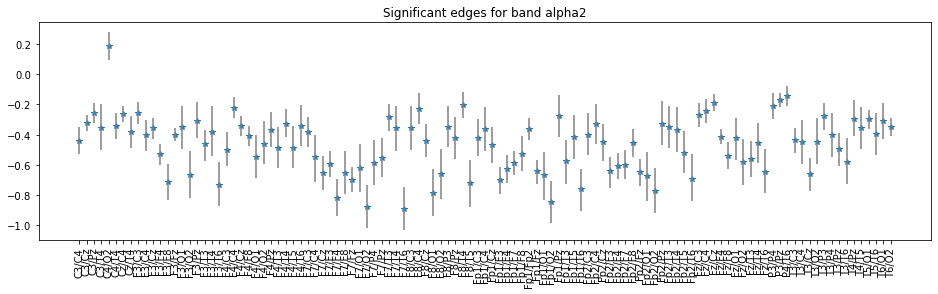

In [26]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
sign_channels = eeg_analyser.significant_channels(band = 4)

In [27]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 100, band = 4, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 15.71it/s]

Средний коэффициент джакарда: 0.7595967949192464


array(['C3/C4', 'C3/Cz', 'C3/Pz', 'C4/T4', 'Cz/C4', 'F3/C3', 'F3/C4',
       'F3/Cz', 'F3/F4', 'F3/F8', 'F3/Fz', 'F3/O2', 'F3/T3', 'F3/T6',
       'F4/C3', 'F4/C4', 'F4/Cz', 'F4/F8', 'F4/O1', 'F4/O2', 'F4/T3',
       'F4/T4', 'F4/T5', 'F7/C3', 'F7/C4', 'F7/Cz', 'F7/F3', 'F7/F4',
       'F7/F8', 'F7/Fz', 'F7/O1', 'F7/O2', 'F7/P4', 'F7/Pz', 'F7/T6',
       'F8/Cz', 'F8/O1', 'F8/O2', 'F8/T5', 'Fp1/C3', 'Fp1/Cz', 'Fp1/F3',
       'Fp1/F4', 'Fp1/F7', 'Fp1/F8', 'Fp1/Fp2', 'Fp1/Fz', 'Fp1/O1',
       'Fp1/O2', 'Fp1/T3', 'Fp1/T6', 'Fp2/Cz', 'Fp2/F3', 'Fp2/F4',
       'Fp2/F7', 'Fp2/F8', 'Fp2/Fz', 'Fp2/O1', 'Fp2/O2', 'Fp2/T5',
       'Fp2/T6', 'Fz/C3', 'Fz/C4', 'Fz/Cz', 'Fz/F4', 'Fz/F8', 'Fz/O1',
       'Fz/O2', 'Fz/T3', 'Fz/T4', 'Fz/T6', 'P3/Pz', 'T3/C3', 'T3/Cz',
       'T3/Pz', 'T3/T6', 'T5/O1', 'T6/O2', 'F7/T3', 'T3/C4', 'T3/O2',
       'Cz/T4', 'Fp1/T5', 'T3/P3', 'F4/Pz', 'F8/Pz'], dtype='<U7')

In [28]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 50, band = 4, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.65it/s]

Средний коэффициент джакарда: 0.48750904360408115


array(['C3/C4', 'C3/Cz', 'C4/T4', 'Cz/C4', 'F3/Cz', 'F3/F4', 'F3/F8',
       'F3/Fz', 'F3/O2', 'F3/T3', 'F3/T6', 'F4/C3', 'F4/Cz', 'F4/F8',
       'F7/Cz', 'F7/F3', 'F7/F4', 'F7/F8', 'F7/Fz', 'F7/O2', 'F7/T6',
       'F8/Cz', 'F8/O1', 'F8/O2', 'F8/T5', 'Fp1/F3', 'Fp1/F4', 'Fp1/F7',
       'Fp1/F8', 'Fp1/Fp2', 'Fp1/Fz', 'Fp1/O2', 'Fp1/T6', 'Fp2/F3',
       'Fp2/F4', 'Fp2/F7', 'Fp2/F8', 'Fp2/Fz', 'Fp2/O1', 'Fp2/O2',
       'Fp2/T6', 'Fz/F4', 'Fz/F8', 'Fz/T3', 'Fz/T6', 'T3/C3', 'T3/Cz',
       'T3/Pz', 'T6/O2', 'Fp1/O1', 'T5/O1', 'F7/O1'], dtype='<U7')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 587.49it/s]


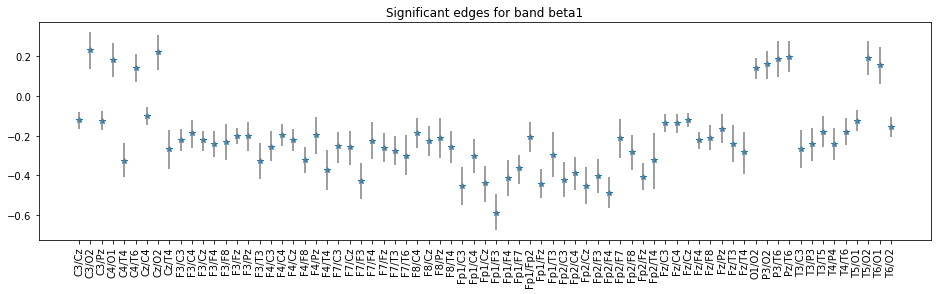

In [29]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
sign_channels = eeg_analyser.significant_channels(band = 5)

In [30]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 100, band = 5, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.22it/s]

Средний коэффициент джакарда: 0.6069533977837165


array(['C3/Cz', 'C4/T4', 'F3/C3', 'F3/Cz', 'F3/F4', 'F3/Fz', 'F3/T3',
       'F4/C3', 'F4/C4', 'F4/Cz', 'F4/F8', 'F4/T4', 'F7/C3', 'F7/Cz',
       'F7/F3', 'F7/Fz', 'F7/T3', 'Fp1/C3', 'Fp1/C4', 'Fp1/Cz', 'Fp1/F3',
       'Fp1/F4', 'Fp1/F7', 'Fp1/Fz', 'Fp2/C3', 'Fp2/C4', 'Fp2/Cz',
       'Fp2/F4', 'Fp2/Fz', 'Fz/C3', 'Fz/C4', 'Fz/Cz', 'Fz/F4', 'T3/P3',
       'T6/O2', 'C3/Pz', 'F8/T4', 'Fp2/F3', 'Fz/F8', 'T4/P4', 'Cz/T4',
       'F7/T6', 'Fp2/F8'], dtype='<U7')

In [31]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 50, band = 5, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.75it/s]

Средний коэффициент джакарда: 0.3234696022072479


array(['F3/C3', 'F3/Cz', 'F3/Fz', 'F4/F8', 'F7/F3', 'Fp1/Cz', 'Fp1/F3',
       'Fp1/F4', 'Fp1/F7', 'Fp1/Fz', 'Fp2/C3', 'Fp2/Cz', 'Fp2/F3',
       'Fp2/F4', 'Fp2/Fz', 'Fz/F4', 'Fp1/C3'], dtype='<U7')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 583.21it/s]


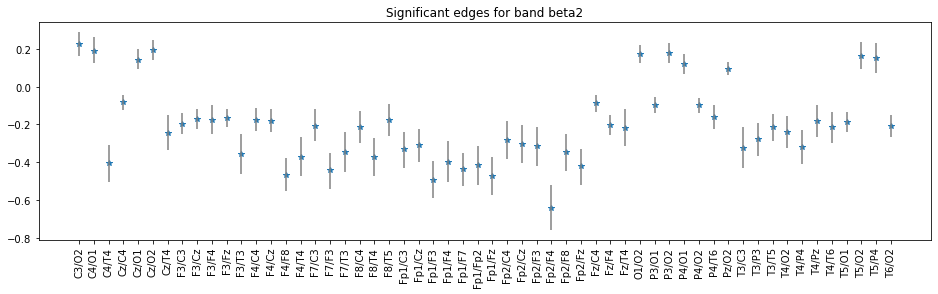

In [32]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
sign_channels = eeg_analyser.significant_channels(band = 6)

In [34]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 100, band = 6, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.30it/s]

Средний коэффициент джакарда: 0.6038523445189138


array(['C3/O2', 'C4/T4', 'F3/C3', 'F3/Cz', 'F3/T3', 'F4/Cz', 'F4/F8',
       'F4/T4', 'F7/F3', 'F7/T3', 'F8/T4', 'Fp1/Cz', 'Fp1/F3', 'Fp1/F7',
       'Fp1/Fp2', 'Fp1/Fz', 'Fp2/F4', 'Fp2/F8', 'Fp2/Fz', 'Fz/F4',
       'O1/O2', 'P3/O2', 'T3/C3', 'T3/P3', 'T5/O1', 'T6/O2', 'Cz/O2',
       'F3/Fz', 'Fp1/C3', 'Fp1/F4', 'Fp2/Cz', 'Fp2/F3', 'T3/T5', 'F4/C4',
       'T4/P4'], dtype='<U7')

In [35]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 50, band = 6, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.66it/s]

Средний коэффициент джакарда: 0.3011297587831932


array(['C4/T4', 'F4/F8', 'F7/F3', 'Fp1/F3', 'Fp1/F7', 'Fp1/Fz', 'T6/O2',
       'F3/C3', 'Fp2/F4', 'Fp2/Fz', 'Fz/F4'], dtype='<U7')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 577.29it/s]


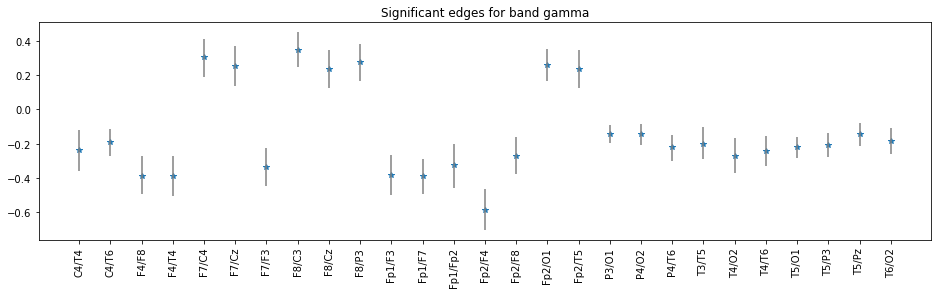

In [36]:
eeg_analyser = EEGPairedPermutationAnalyser(data_df = df, thres = 0.001, num_perm = 1000)
sign_channels = eeg_analyser.significant_channels(band = 7)

In [37]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 100, band = 7, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 16.13it/s]

Средний коэффициент джакарда: 0.38490427697016716


array(['F7/F3', 'F8/C3', 'Fp1/F3', 'Fp1/F7', 'Fp2/F4', 'T5/O1', 'T5/P3',
       'F4/T4', 'F4/F8', 'P3/O1', 'P4/T6'], dtype='<U7')

In [38]:
# Посмотрим воспроизводимость паттерна целиком и  каналы, которые воспроизводятся чаще всего при бутстрепинге
num_reps = 50
(jac_list,cnt), sign_etalon, sign_tested  = eeg_analyser.compare_to_etalon(size = 50, band = 7, num_reps = num_reps)

print(f"Средний коэффициент джакарда: {np.mean(jac_list)}")
most_frequent = { x: count for x, count in cnt.items() if count >= num_reps*0.5}
eeg_analyser.channel_bivar[list(most_frequent.keys())]

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.70it/s]

Средний коэффициент джакарда: 0.1339700195984957


array(['Fp2/F4'], dtype='<U7')

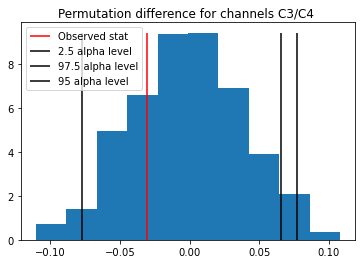

In [90]:
eeg_analyser.plot_chnl_perm_test(emp_stat = emp_mean_diffs, perm_stats = perm_mean_diffs, ch_idx=0)

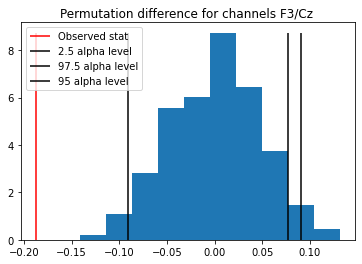

In [91]:
eeg_analyser.plot_chnl_perm_test(emp_stat = emp_mean_diffs, perm_stats = perm_mean_diffs, ch_idx=29, band = 2)

In [92]:
sign_channels = eeg_analyser.significant_channels(thres = 0.00001, band = 2)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]


KeyError: "None of [Index(['C3/C4_2_fo', 'C3/Cz_2_fo', 'C3/O1_2_fo', 'C3/O2_2_fo', 'C3/P3_2_fo',\n       'C3/P4_2_fo', 'C3/Pz_2_fo', 'C3/T4_2_fo', 'C3/T5_2_fo', 'C3/T6_2_fo',\n       ...\n       'T4/T5_2_fo', 'T4/T6_2_fo', 'T5/O1_2_fo', 'T5/O2_2_fo', 'T5/P3_2_fo',\n       'T5/P4_2_fo', 'T5/Pz_2_fo', 'T5/T6_2_fo', 'T6/O1_2_fo', 'T6/O2_2_fo'],\n      dtype='object', length=171)] are in the [columns]"

In [332]:
channel_bivar[sign_connections]

array(['F3/C3', 'F3/Cz', 'F3/Fz', 'F3/Pz', 'F3/T3', 'F4/T4', 'F7/F3',
       'F7/T3', 'Fp1/C3', 'Fp1/C4', 'Fp1/Cz', 'Fp1/F3', 'Fp1/F4',
       'Fp1/Fz', 'Fp1/T3', 'Fp2/C3', 'Fp2/C4', 'Fp2/Cz', 'Fp2/F4',
       'Fp2/Fz', 'Fp2/T4', 'Fz/C3', 'Fz/T3', 'O1/O2', 'P3/O2', 'Pz/O2'],
      dtype='<U7')

In [339]:
a, b, c = 2, 3, None

(a or b or c)

2

In [341]:
all([a,b,c])

True

In [324]:
def permut_difference_paired(df, num_shuffles=1000, channel_bivar = channel_bivar, r='1'):
    
    
    df = df.copy()
    open_name = [f'{channel_bivar[i]}_{r}_fo' for i in range(len(channel_bivar))]
    close_name = [f'{channel_bivar[i]}_{r}_fz' for i in range(len(channel_bivar))]
    
    emp_diffs =  df[open_name].values - df[close_name].values
    
    emp_mean_diffs = emp_diffs.mean(axis=0)
    emp_errors = emp_diffs.std(axis=0)

    perm_mean_diffs = np.zeros((num_shuffles, emp_diffs.shape[1]))
    for k in tqdm(np.arange(num_shuffles)):
        perm_mean_diffs[k,:] = (np.random.choice([1,-1], emp_diffs.shape[0]).reshape(-1,1)*emp_diffs).mean(axis=0)
    p_val = np.mean(np.abs(shuffled_mean_diffs)>np.abs(emp_mean_diffs), axis=0) 
    return (emp_mean_diffs, emp_errors), perm_mean_diffs, p_val

def bootstrap_patients(df, size = 70, replace = False):
    df_small = df.loc[list(np.random.choice(df.index, size = size, replace=replace))]
    return df_small
    

def plot_distribution(emp_stat, perm_stats, ch_idx=0, channel_bivar = channel_bivar):
    val = plt.hist(perm_stats[:,ch_idxs], density = True)
    plt.vlines(emp_stat[ch_idxs], 0, max(val[0]), 'red',  label = 'Observed stat');
    plt.vlines(np.percentile(perm_stats[:,ch_idxs], 2.5), 0, max(val[0]), 'black',  label = '2.5 alpha level');
    plt.vlines(np.percentile(perm_stats[:,ch_idxs], 97.5), 0, max(val[0]), 'black', label = '97.5 alpha level');
    plt.vlines(np.percentile(perm_stats[:,ch_idxs], 95), 0, max(val[0]), 'black', label = '95 alpha level');
    plt.title(f"Permutation difference for channels {channel_bivar[ch_idxs]} ")
    plt.legend();
    
def plot_significant_channels(emp_mean_diffs, emp_errors, p_val, thres = 0.0001):
    
    sign_connections = np.where(p_val<thres)[0]
    fig, ax = plt.subplots(2,1, figsize = (16,8))

ax[0].errorbar(range(85), mean_diffs[:85], yerr=errors[85], 
         fmt='*', capsize=2, elinewidth=0.5, 
         markeredgewidth=0.5);
ax[0].set_xticks(range(85))
ax[0].set_xticklabels(channel_bivar[:85], rotation=90, fontsize=8);

ax[1].errorbar(range(85,171), mean_diffs[85:], yerr=errors[85:], 
         fmt='*', linewidth = 1, capsize=2, elinewidth=0.5, 
         markeredgewidth=0.5);
ax[1].set_xticks(range(85, 171))
ax[1].set_xticklabels(channel_bivar[85:], rotation=90, fontsize=8);
    
   

#нарисовать графики с ошибками для суперзначимых

In [315]:
len(df.index)

177

In [329]:
thres = 0.00001
emp_mean_diffs, perm_mean_diffs, p_val =  permut_difference_paired(df, num_shuffles=5000)
sign_connections = np.where(p_val<thres)[0]

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 10143.78it/s]


In [331]:
emp_mean_diffs[sign_connections]

array([-0.23357807, -0.18769261, -0.14265521, -0.25330345, -0.30993153,
       -0.21330904, -0.24128864, -0.33798944, -0.4500309 , -0.34126808,
       -0.36473254, -0.41249561, -0.32053214, -0.38034964, -0.41943544,
       -0.4119092 , -0.39341414, -0.41070061, -0.36586426, -0.32371019,
       -0.45549705, -0.13098128, -0.29097362,  0.20968775,  0.19905384,
        0.19544754])

In [323]:
emp_mean_diffs, perm_mean_diffs, p_val =  permut_difference_paired(bootstrap_patients(df, size = 90, replace=False), num_shuffles=5000)
sign_connections_small = np.where(p_val<thres)[0]
jaccard(sign_connections,sign_connections_small)

100%|████████████████████████████████████| 5000/5000 [00:00<00:00, 11605.02it/s]


0.6129032258064516

0.1346153846153846

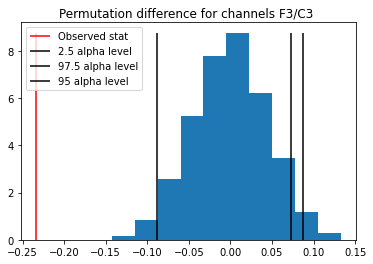

In [258]:
plot_distribution(emp_mean_diffs, perm_mean_diffs, ch_idx=29)

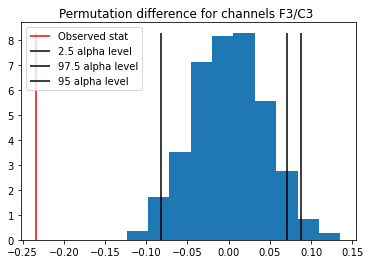

In [252]:
ch_idxs=27
val = plt.hist(perm_mean_diffs[:,ch_idxs], density = True)
plt.vlines(emp_mean_diffs[ch_idxs], 0, max(val[0]), 'red',  label = 'Observed stat');
plt.vlines(np.percentile(perm_mean_diffs[:,ch_idxs], 2.5), 0, max(val[0]), 'black',  label = '2.5 alpha level');
plt.vlines(np.percentile(perm_mean_diffs[:,ch_idxs], 97.5), 0, max(val[0]), 'black', label = '97.5 alpha level');
plt.vlines(np.percentile(perm_mean_diffs[:,ch_idxs], 95), 0, max(val[0]), 'black', label = '95 alpha level');
plt.title(f"Permutation difference for channels {channel_bivar[ch_idxs]} ")
plt.legend();

In [240]:
perm_mean_difff[:,]

(1000, 171)

In [239]:
emp_mean_diffs[0]

-0.030351434717177942

In [235]:
pd.DataFrame(np.array([mean_diffs, p_val, errors]).T, columns = ['mean_diffs','p_val','errors'])

,mean_diffs,p_val,errors
0,-0.030351,0.468,0.538953
1,-0.060581,0.094,0.472929
2,0.024534,0.719,0.842379
3,0.175922,0.006,0.824021
4,0.011370,0.796,0.572207
...,...,...,...
166,0.075835,0.204,0.815889
167,-0.001777,0.976,0.775491
168,-0.000254,0.994,0.869776
169,0.072905,0.154,0.673364


In [225]:
r=1
num_shuffles = 10000
open_name = [f'{channel_bivar[i]}_{r}_fo' for i in range(len(channel_bivar))]
close_name = [f'{channel_bivar[i]}_{r}_fz' for i in range(len(channel_bivar))]
    
emp_diffs =  df[open_name].values - df[close_name].values
    
emp_mean_diffs = emp_diffs.mean(axis=0)
emp_errors = emp_diffs.std(axis=0)

shuffled_mean_diffs = np.zeros((num_shuffles, emp_diffs.shape[1]))
for k in tqdm(np.arange(num_shuffles)):
    
    shuffled_mean_diffs[k,:] = (np.random.choice([1,-1], df.shape[0]).reshape(-1,1)*emp_diffs).mean(axis=0)
p_val = np.mean(np.abs(shuffled_mean_diffs)>np.abs(emp_mean_diffs), axis=0)    

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 10070.69it/s]


In [227]:
p_val[p_val<0.001]

array([0.0001, 0.0005, 0.0006, 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.0002, 0.    , 0.0002, 0.    , 0.    , 0.0007, 0.0006, 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.0008, 0.0008, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.0002, 0.    , 0.    , 0.    , 0.    ,
       0.0003, 0.    , 0.0005, 0.    , 0.    , 0.    , 0.0005, 0.0001])

In [208]:
#np.sign(emp_mean_diffs)

In [210]:
shuffled_mean_diffs[:,0]

array([-0.02310369,  0.02706314, -0.02068902, -0.0397924 , -0.01021366,
        0.00316866, -0.01281499, -0.02649753, -0.01604602, -0.01766964])

In [219]:
np.mean(np.abs(shuffled_mean_diffs)>np.abs(emp_mean_diffs), axis=0)

array([0.1, 0. , 0.7, 0. , 0.8, 0.1, 0.3, 0. , 0.9, 0.1, 0.1, 0. , 0. ,
       0. , 0.8, 0. , 0.5, 0. , 0.5, 0.1, 0. , 0. , 0.1, 1. , 0. , 0.9,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 1. , 0. , 0.3, 0. , 0. ,
       0.6, 0. , 0.1, 0. , 0. , 0. , 0.1, 0.2, 0.4, 0.7, 0.6, 0.1, 0.1,
       0. , 0.1, 0.5, 0. , 0.7, 0.2, 0. , 1. , 0. , 0. , 0.5, 0.6, 0.1,
       0.8, 0.4, 0. , 0.4, 0. , 0.6, 0.7, 0.4, 0.2, 0.5, 0.7, 0. , 0.4,
       0.1, 0.2, 0. , 0.8, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
       0. , 0.7, 0.2, 0. , 0.7, 0.2, 0. , 0.4, 0. , 0.1, 0. , 0. , 0. ,
       0. , 0. , 0. , 0.4, 0. , 0.5, 0.9, 0. , 0.2, 0.3, 0.1, 0. , 0.1,
       0.9, 0. , 0.1, 0.1, 0. , 0.9, 1. , 1. , 0.9, 0.7, 0.1, 0. , 0. ,
       0. , 0.5, 0. , 0.3, 0. , 0. , 0.1, 0. , 0. , 1. , 0.8, 0. , 0. ,
       0. , 0. , 0. , 0.1, 0. , 0. , 0.3, 0. , 0.5, 0. , 0.6, 0. , 0.4,
       0.1, 0.3, 0.7, 0.1, 0.1, 0. , 0.9, 0. , 0.1, 0.2, 0.2, 1. , 1. ,
       0.1, 0. ])

In [200]:
shuffled_mean_diffs.shape

(10, 2394)

In [196]:
(np.random.choice([1,-1], df.shape[0]).reshape(-1,1)*emp_diffs).mean(axis=0)

array([ 3.28915577e-02,  6.74631119e-02,  2.09216761e-01,  1.73270702e-01,
        8.05009500e-02,  6.21317778e-02,  6.51773687e-02,  1.26672479e-01,
        2.51699297e-02,  1.34051472e-01,  1.56030245e-01,  6.85873778e-02,
        1.87224146e-02, -2.60575532e-02, -9.26871558e-03, -3.76060921e-03,
        1.22039257e-01,  6.42263779e-02, -1.68955143e-02,  1.84129809e-01,
        1.69491433e-01,  9.18969074e-02,  6.91985330e-02,  2.16648461e-02,
        1.95297715e-02,  1.42621094e-01,  1.07383428e-01, -2.55041085e-02,
       -4.08301884e-03, -2.08392937e-02, -3.63777622e-02, -4.12517571e-02,
       -3.26599839e-02,  1.60482609e-01,  1.72786320e-01,  9.46324193e-02,
        8.05638657e-02,  2.63969016e-02,  5.71762756e-03,  4.70483532e-02,
        1.46093292e-01,  1.10458045e-01, -3.89738976e-02, -1.39757466e-02,
       -1.18001509e-02,  1.19510877e-02, -7.54068037e-04,  1.28329055e-01,
        5.04177916e-02,  1.00825753e-01,  1.49121197e-02,  4.28136737e-02,
       -2.96755874e-02,  

In [177]:
test_arr = df[open_name].values

In [162]:
test_arr.shape

(177, 171)

In [146]:
emp_mean_diffs[0]

-0.030351434717177942

In [159]:
shuffled_labels = np.array([np.random.permutation(labels[i]) for i in range(len(labels))])
diff = df[shuffled_labels[:, 0]].values - df[shuffled_labels[:, 1]].values
print(shuffled_labels[:10])
diff[:10,0]

[['C3/C4_1_fz' 'C3/C4_1_fo']
 ['C3/Cz_1_fz' 'C3/Cz_1_fo']
 ['C3/O1_1_fo' 'C3/O1_1_fz']
 ['C3/O2_1_fo' 'C3/O2_1_fz']
 ['C3/P3_1_fo' 'C3/P3_1_fz']
 ['C3/P4_1_fo' 'C3/P4_1_fz']
 ['C3/Pz_1_fz' 'C3/Pz_1_fo']
 ['C3/T4_1_fz' 'C3/T4_1_fo']
 ['C3/T5_1_fo' 'C3/T5_1_fz']
 ['C3/T6_1_fo' 'C3/T6_1_fz']]


array([-0.0453244 ,  0.76817686,  0.26188459,  0.97364937,  0.07964483,
        0.32448946, -0.28069729, -0.25300598, -0.04099411, -0.17322965])

In [153]:
diff.shape

(177, 171)

In [145]:
np.array(shuffled_mean_diffs)[:,0]

array([ 0.03035143,  0.03035143, -0.03035143, -0.03035143, -0.03035143,
       -0.03035143, -0.03035143,  0.03035143,  0.03035143,  0.03035143])

In [138]:
mean_diffs, errors, p_val = compute_difference(df, num_shuffles=10, r='1')

100%|███████████████████████████████████████████| 10/10 [00:48<00:00,  4.89s/it]


In [139]:
shuffled_mean_diffs

NameError: name 'shuffled_mean_diffs' is not defined

## Для дельта ритма

Надо сделать отдельно для всех ритмов. Очень важно чтобы у нас совпадал порядок канал - канал, чтобы мы из одинаковых пар каналов открытые и закрытые глаза смотрели разницу

In [89]:
open_name_delta = [f'{channel_bivar[i]}_1_fo' for i in range(171)]
close_name_delta = [f'{channel_bivar[i]}_1_fz' for i in range(171)]
labels = np.array([open_name, close_name]).T
shuffled_labels = np.array([np.random.permutation(labels[i]) for i in range(len(labels))])

In [90]:
diff_delta = df[open_name_delta].values - df[close_name_delta].values

In [91]:
mean_diffs = diff_delta.mean(axis=0)
errors = diff_delta.std(axis=0)

In [102]:
labels = np.concatenate([np.zeros((171,1)), np.ones((171,1))], axis=1)

In [93]:
# очень хочется посмотреть что там, но пока так только, надо бы головки научиться рисовать, как у Данько.

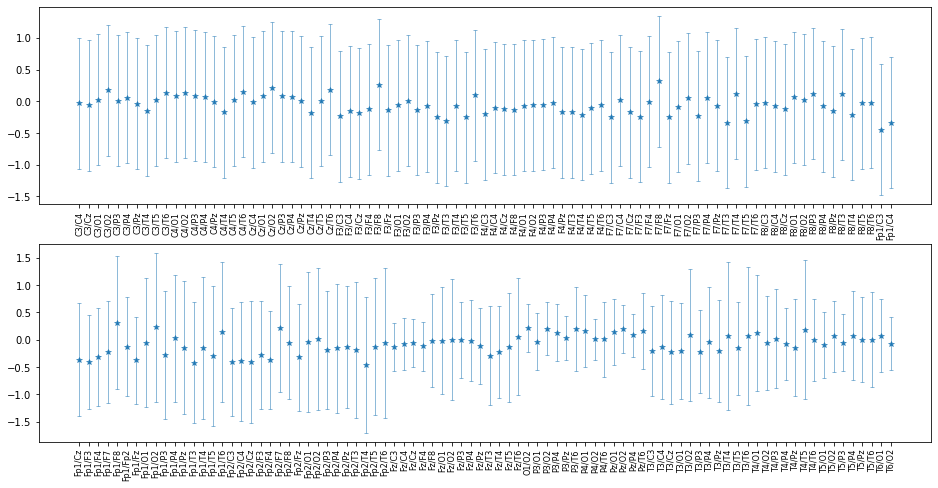

In [92]:
fig, ax = plt.subplots(2,1, figsize = (16,8))

ax[0].errorbar(range(85), mean_diffs[:85], yerr=errors[85], 
         fmt='*', capsize=2, elinewidth=0.5, 
         markeredgewidth=0.5);
ax[0].set_xticks(range(85))
ax[0].set_xticklabels(channel_bivar[:85], rotation=90, fontsize=8);

ax[1].errorbar(range(85,171), mean_diffs[85:], yerr=errors[85:], 
         fmt='*', linewidth = 1, capsize=2, elinewidth=0.5, 
         markeredgewidth=0.5);
ax[1].set_xticks(range(85, 171))
ax[1].set_xticklabels(channel_bivar[85:], rotation=90, fontsize=8);